In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [6]:
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [7]:
#Precipitation Data
session = Session(engine)

In [8]:
precip_data = session.query(Measurements).first()
precip_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a0b65d7b8>,
 'date': datetime.date(2010, 1, 1),
 'meas_id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [9]:
from datetime import datetime
most_current = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
last_date = most_current[0]
year_before = last_date.replace(year = (last_date.year - 1))
year_before = year_before.strftime("%Y-%m-%d")
year_before

'2016-08-23'

In [10]:
twelve_months = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date > year_before)
twelve_months_prcp = pd.read_sql_query(twelve_months.statement, engine, index_col = 'date')

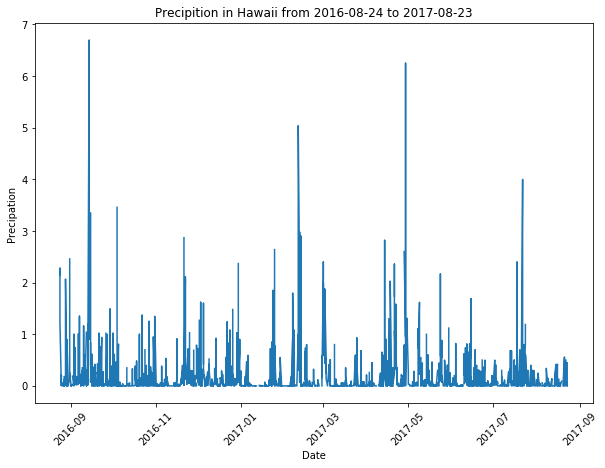

In [11]:
twelve_months_prcp.plot(figsize = (10,7), rot = 45, use_index = True, legend=False)
plt.ylabel('Precipation')
plt.xlabel('Date')
plt.title("Precipition in Hawaii from %s to %s" % (twelve_months_prcp.index.min(),twelve_months_prcp.index.max()))
plt.show()

In [12]:
station_data = session.query(Stations).first()
station_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a0b684b38>,
 'elevation': 3.0,
 'id': 1,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

In [13]:
from sqlalchemy import func
num_stations = session.query(Stations.station).group_by(Stations.station).count()

In [14]:
activity = session.query(Stations.station, Stations.name, Measurements.station, func.count(Measurements.tobs)).filter(Stations.station == Measurements.station).group_by(Measurements.station).order_by(func.count(Measurements.tobs).desc()).all()

In [15]:
max_activity = activity[0][0:2]

In [16]:
temps_maxact = session.query(Measurements.station, Measurements.tobs).filter(Measurements.station == max_activity[0], Measurements.date > year_before).all()

In [17]:
len(temps_maxact)

351

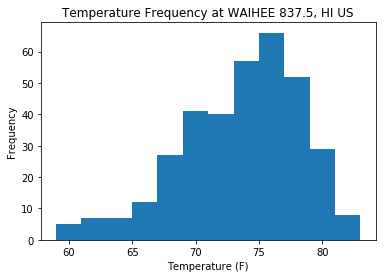

In [18]:
temps = [x[1] for x in temps_maxact]
plt.hist(temps, bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperature Frequency at %s" % (max_activity[1]))
plt.show()

In [19]:
def calc_temps(start_date, end_date):
    #create dates 1 year prior
    dates = [start_date, end_date]
    new_dates = []
    for date in dates:
        date_list = date.split("-")
        date_list[0] = str(int(date_list[0]) - 1)
        new_date = "-".join(date_list)
        new_dates.append(new_date)
    print(new_dates) 
    
    #query database for temps from those dates
    temp_values = session.query(Measurements.tobs).filter(Measurements.date >= new_dates[0], Measurements.date <= new_dates[1]).all()
    temp_values_list = [x for (x,) in temp_values]
    avg_temp = np.mean(temp_values_list)
    max_temp = max(temp_values_list)
    min_temp = min(temp_values_list)
    
    # create bar graph
    plt.figure(figsize=(2,5))
    plt.title("Trip Average Temp")
    plt.ylabel("Temperature (F)")
    plt.bar(1, avg_temp, yerr = (max_temp - min_temp), tick_label = "")
    plt.show()

['2017-06-01', '2017-06-14']


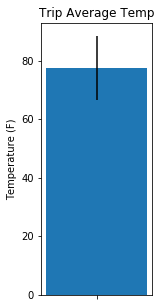

In [20]:
calc_temps('2018-06-01', '2018-06-14')

In [22]:
def daily_normals(chosen_date):
    temps = session.query(Measurements.tobs).filter(Measurements.date.like('%'+chosen_date)).all()
    obs = [x for (x), in temps]
    return obs
    
start_date = '06-01'
end_date = '06-14'

In [23]:
def create_date_list(start_date, end_date):
    start_month = start_date.split("-")[0]
    end_month = end_date.split("-")[0]
    
    start_day = int(start_date.split("-")[1])
    end_day = int(end_date.split("-")[1])
    
    if start_month == end_month:
        diff = end_day - start_day
        days = [start_day + x for x in range(0,diff + 1) ]
    
    else:
        diff1 = 31 - start_day
        days1 = [start_day + x for x in range(0,diff1 + 1)]
        days2 = [x for x in range(1, end_day + 1)]
        days = days1 + days2
        
    days_str = [('%s-%s' % (start_month, str(x))) if len(str(x)) == 2 else ('%s-0%s' % (end_month, str(x))) for x in days]
    return days_str

In [26]:
def query_results(start, end):
    dates = create_date_list(start, end)
    master_dict = {"Date": [], "Max Temp": [], "Min Temp": [], "Average Temp": []}
    for date in dates:
        data_list = []
        observations = daily_normals(date)
        if observations != []:
            for temp in observations:
                data_list.append(temp)
            master_dict['Date'].append(date)
            master_dict['Max Temp'].append(max(data_list))
            master_dict['Min Temp'].append(min(data_list))
            master_dict['Average Temp'].append(round(np.mean(data_list),2))
            master_dict
    return(master_dict)
normals_df = pd.DataFrame(query_results('06-01', '06-14')).set_index('Date')

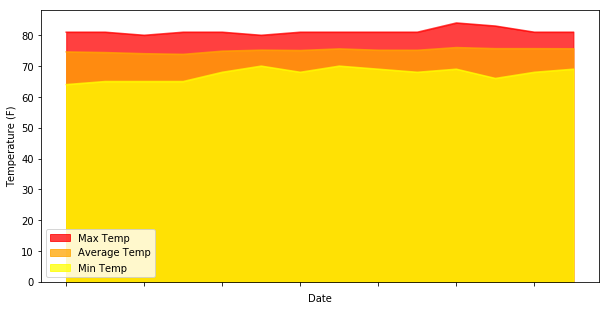

In [28]:
normals_df = normals_df[['Max Temp', 'Average Temp', 'Min Temp']]

normals_df.plot(kind = 'area', stacked = False, alpha = .75, rot = 45, color = ['red', 'orange', 'yellow'], figsize = (10,5), linestyle = 'solid')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.legend(frameon = True)
plt.show()